In [1]:
import mtcnn
print(mtcnn.__version__)

0.1.0


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot 
from keras.models import load_model
from PIL import Image
import matplotlib as plt

In [8]:
import os

In [9]:
img = cv2.imread('./datas/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

AttributeError: module 'matplotlib' has no attribute 'imshow'

In [5]:
from keras import backend

In [6]:

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('./datas/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

NameError: name 'plt' is not defined

In [7]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('./datas/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./datas/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('faces-dataset.npz', trainX, trainy, testX, testy)

loaded 14 sample for class: ben_afflek


loaded 17 sample for class: elton_john


loaded 21 sample for class: jerry_seinfeld


loaded 19 sample for class: madonna


loaded 22 sample for class: mindy_kaling
(93, 160, 160, 3) (93,)


loaded 5 sample for class: ben_afflek


loaded 5 sample for class: elton_john


loaded 5 sample for class: jerry_seinfeld


loaded 5 sample for class: madonna


loaded 5 sample for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [13]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [14]:
#from keras.models import load_model
from tensorflow.keras.models import load_model
import tensorflow as tf
# load the facenet model
facenet_model = load_model('./facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [16]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(93, 128)
(25, 128)


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
#print(emdTestX_norm)
#print(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[87.53613185  5.02183009  2.42081526  2.03458561  2.98663718]
Expected: ben_afflek


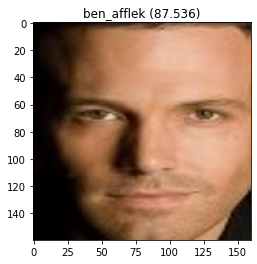

In [18]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[87.53021363  3.69347345  1.42000067  3.47891375  3.8773985 ]
Expected: ben_afflek


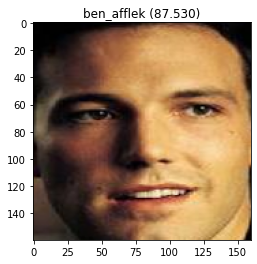

In [344]:

random_face = testX[0]
random_face_emd = emdTestX_norm[0]
random_face_class = testy_enc[0]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


In [189]:
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[0]
#random_face_emd = emdTestX_norm[0]
#plt.imshow(random_face_emd)
random_face.shape
#emdTestX_norm.shape
#print(selection)

(160, 160, 3)

In [167]:
def facen(path):
    #img = cv2.imread(path)
    random_face = testX[24]
    random_face_emd = emdTestX_norm[24]
    random_face_class = testy_enc[24]
    random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
    samples = np.expand_dims(random_face_emd, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
# get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    #print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
    #print('Expected: %s' % random_face_name[0])
# plot face
    #cv2.imshow(random_face)
    #cv2.imwrite('./static/predict/{}'.format(filename),random_face)
    plt.imshow(random_face)
    return random_face_name[0]

In [168]:
facen(path)

NameError: name 'path' is not defined

In [278]:
img = cv2.imread('1.jpg')

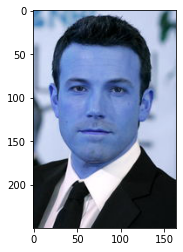

In [279]:
plt.imshow(img)

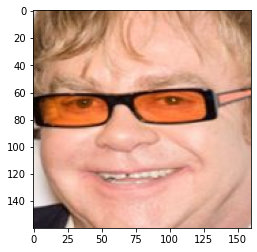

(160, 160, 3)


In [532]:
px = extract_face('2.jpg')
plt.imshow(px)
plt.show()
print(px.shape)

In [533]:
em = get_embedding(facenet_model, px)


In [534]:
emdTest=list()
emdTest.append(em)
emdTest = np.asarray(emdTest)


In [535]:
emdTest.shape[0]

1

In [536]:
in_encoder = Normalizer()

In [537]:
emdTest_norm = in_encoder.transform(emdTest)


In [538]:
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
#testy_enc = out_encoder.transform(testy)

In [539]:
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTest_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
#score_test = accuracy_score(testy_enc, yhat_test)
print(score_train)
#print(score_test)

1.0


In [540]:
print(yhat_test)

[1]


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 0.9814485  91.29320437  1.61402835  3.82887122  2.28244756]
Expected: ['elton_john']


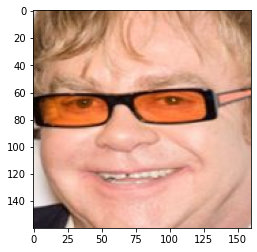

In [541]:
face = px
face_emd = emdTest_norm[0]
#face_class = testy_enc[1]
#face_name = out_encoder.inverse_transform([face_class])

# prediction for the face
sample = np.expand_dims(face_emd, axis=0)
yhat_c = model.predict(sample)
yhat_p = model.predict_proba(sample)
# get name
class_in = yhat_c[0]
class_prob = yhat_p[0,class_in] * 100
predict_name = out_encoder.inverse_transform(yhat_c)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_p[0]*100))
print('Expected: %s' % predict_name)
# plot face
    #cv2.imshow(random_face)
    #cv2.imwrite('./static/predict/{}'.format(filename),random_face)
plt.imshow(face)



In [542]:
print(class_in)

1


In [543]:
print(yhat_c[0])

1


In [544]:
print(face_class)

0


In [545]:
print(predict_name)

['elton_john']


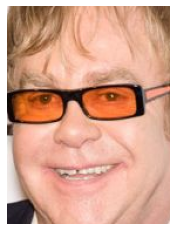

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 2.69975249 77.05798742  1.84278779 13.78135878  4.61811352]
Expected: ['elton_john']


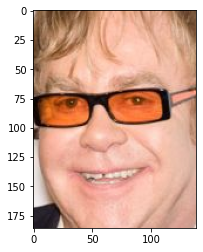

In [22]:
image = Image.open('2.jpg')
#data = pyplot.imread(filename)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = np.asarray(image)
# create the detector, using default weights
em = get_embedding(facenet_model, pixels)
emdTest=list()
emdTest.append(em)
emdTest = np.asarray(emdTest)
in_encoder = Normalizer()
emdTest_norm = in_encoder.transform(emdTest)
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTest_norm)

detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels) 
# extract the bounding box from the first face
#print(results)
for i in range(len(results)):
    x1, y1, width, height = results[i]['box']
    x2, y2 = x1 + width, y1 + height
    pyplot.subplot(1, len(results), i+1)
    #face = pixels[y1:y2, x1:x2]
    #print(len(results))
    #pyplot.axis('off')
    #pyplot.imshow(pixels[y1:y2, x1:x2])
    face = pixels[y1:y2, x1:x2]
    face_emd = emdTest_norm[0]
#face_class = testy_enc[1]
#face_name = out_encoder.inverse_transform([face_class])

# prediction for the face
    sample = np.expand_dims(face_emd, axis=0)
    yhat_c = model.predict(sample)
    yhat_p = model.predict_proba(sample)
# get name
    class_in = yhat_c[0]
    class_prob = yhat_p[0,class_in] * 100
    predict_name = out_encoder.inverse_transform(yhat_c)
    all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Predicted: \n%s \n%s' % (all_names, yhat_p[0]*100))
    print('Expected: %s' % predict_name)
# plot face
    #cv2.imshow(random_face)
    #cv2.imwrite('./static/predict/{}'.format(filename),random_face)
    plt.imshow(face)

In [23]:
print(yhat_c)

[1]
